**Part 1: Preprocessing Data**

Please note that the original preprocessing code and training files were run on different files separately.

Created by : Myat Ma De May Phuu Ngon (26002304901)

In [ ]:
# Myat Ma De May Phuu Ngon
# 26002304901

# Importing necessary libraries
import pandas as pd
import re                                       #For regular expressions
from sklearn.preprocessing import LabelEncoder  #For encoding categorical variables
from google.colab import drive

# Mounting Google Drive for data access
drive.mount('/content/drive')

# Function for cleaning abstract text
def clean_text(text):
  """Clean data step by step and returns the cleaned text"""
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # Remove URLs
    text = re.sub(r"<.*?>", "", text)  # Remove HTML tags
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove special characters (retain alphanumeric)
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    return text

# Function to clean and save a dataset
def clean_and_save_dataset(file_path, label_name, save_path):
    # Loading dataset
    df = pd.read_csv(file_path)

    # Dropping missing values in the 'Abstract' column
    df = df.dropna(subset=["Abstract"]).reset_index(drop=True)

    # Removing duplicate abstracts
    df = df.drop_duplicates(subset="Abstract").reset_index(drop=True)

    # Cleaning the text in the 'Abstract' column
    df["Abstract"] = df["Abstract"].apply(clean_text)

    # Adding the label column
    df["Label"] = label_name

    # Saving the cleaned dataset to directory
    df.to_csv(save_path, index=False)
    print(f"Cleaned {label_name} dataset saved to {save_path}")
    return df

# Paths to the raw CSV files in Google Drive to access
astronomy_file = '/content/drive/My Drive/AI/Astronomy_abstracts.csv'
psychology_file = '/content/drive/My Drive/AI/Psychology_abstracts.csv'
sociology_file = '/content/drive/My Drive/AI/Sociology_abstracts.csv'

# Saving paths for cleaned CSV files in Google Drive
cleaned_astronomy_file = '/content/drive/My Drive/AI/cleaned_astronomy.csv'
cleaned_psychology_file = '/content/drive/My Drive/AI/cleaned_psychology.csv'
cleaned_sociology_file = '/content/drive/My Drive/AI/cleaned_sociology.csv'

# Clean and save datasets individually
astronomy_df = clean_and_save_dataset(astronomy_file, "Astronomy", cleaned_astronomy_file)
psychology_df = clean_and_save_dataset(psychology_file, "Psychology", cleaned_psychology_file)
sociology_df = clean_and_save_dataset(sociology_file, "Sociology", cleaned_sociology_file)

# Combining all cleaned datasets
combined_df = pd.concat([astronomy_df, psychology_df, sociology_df], ignore_index=True)

# Encoding labels numerically
label_encoder = LabelEncoder()
combined_df["Label"] = label_encoder.fit_transform(combined_df["Label"])

# To save the label mapping for reference
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(f"Label Mapping: {label_mapping}")

# Save the combined cleaned dataset to Google Drive in a new csv file, put print statement to see action done
combined_file = '/content/drive/My Drive/AI/combined_cleaned_data.csv'
combined_df.to_csv(combined_file, index=False)
print(f"Combined cleaned dataset saved to {combined_file}")



In [ ]:
# Load the cleaned combined dataset and read
combined_file = '/content/drive/My Drive/AI/combined_cleaned_data.csv'
df = pd.read_csv(combined_file)

# Checking if there is any duplicate to be sure, before we put into the training code
duplicates = df.duplicated(subset="Abstract", keep=False)
print(f"Number of duplicate abstracts: {duplicates.sum()}")

# Checking if there is any missing values
print(df["Label"].value_counts())
# Checking if there is any missing abstracts
print(df["Abstract"].value_counts())

**Part 2: Training**

In [ ]:
# Importing necessary libraries
from sklearn.model_selection import StratifiedKFold # for k-fold cross validation
import numpy as np  # Numpy for numerical operations
import pandas as pd # Pandas for data manipulation
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer #Importing the model for this project, BERT
from sklearn.metrics import accuracy_score, precision_recall_fscore_support # the metrics for evaluation after training
import torch # Pytorch for deep learning
from torch.utils.data import Dataset    # for custom datasets
from sklearn.metrics import classification_report # classification metrics

In [ ]:
# Loading the cleaned combined dataset from drive and
# Reading my dataset into a pandas dataframe
combined_file = '/content/drive/My Drive/AI/combined_cleaned_data.csv'
df = pd.read_csv(combined_file)

# Preparing Stratified k-fold for cross validation
# Number of folds is 5; this is going to be alternated between training and validating
# Initialized with 5 folds, random state is given an int to make the results reproducible while shuffled on
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize the BERT tokenizer and we used the pre-trained bert-base-uncased model, which ignores case of text
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
num_labels = df["Label"].nunique()  # returns number of unique labels in dataset

In [ ]:
# This is for initialixing a custom dataset class for BERT
class BERTDataset(Dataset):
    """We have texts, labels, tokenizer and max_length for tokenization by using PyTorch
    Args:
        texts (list): List of texts to be tokenized
        labels (list): List of labels for the texts
        tokenizer (object): Tokenizer object from Hugging Face's transformers library
        max_length (int): Maximum length of the tokenized text
    Returns:
        PyTorch tensor of encoded text, attention mask applied and label
    """
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        """
        Returns: the number of label samples in the dataset"""
        return len(self.labels)

    def __getitem__(self, idx):
        """Tokenizes the text and returns the tokenized text and label.
        Max length is used for padding and truncation. Truncation is for cutting off text longer than max length.
        Padding is adding zeros to text shorter than max length.
        Returns PyTorch tensor of encoded text, attention mask applied and label.
        Tensors are a core PyTorch data structure to store and manipulate inputs and outputs of a model, similar to NumPy.
        Input IDs are the result of tokenizing the abstract.
        Attention mask is for differentiating between padding and actual text. (0 for padding, 1 for actual text)

        Returns:
            Dictionary of input_ids, attention_mask and label"""
        text = self.texts[idx]      #Gets the text at the index
        label = self.labels[idx]    #Gets the label at the index
        #Tokenizes the text
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),  #Input IDs tensor, squeeze(0) removes the extra dimension
            "attention_mask": encoding["attention_mask"].squeeze(0),    #Attention mask tensor, extra dimension removed
            "labels": torch.tensor(label, dtype=torch.long),    #Labels tensor, converted to long data type
        }

In [ ]:
def compute_metrics(pred):
    "This is the function to compute the metrics for evaluation"
    labels = pred.label_ids                         #True labels
    preds = np.argmax(pred.predictions, axis=1)     #Predicted labels
    accuracy = accuracy_score(labels, preds)        #For accuracy
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")   #For precision, recall and f1-score
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}   #Returns the four metrics

Actual Training and Metrics results

In [ ]:
# A list is initialized to store results for each fold
fold_results = []

# Loop through each fold for training and validation
for fold, (train_idx, val_idx) in enumerate(skf.split(df["Abstract"], df["Label"])):
    print(f"\nStarting training for Fold {fold + 1}/{num_folds}")   #Prints the current fold number (1-5)

    # Split Abstract data and their respecitve labels into training and validation sets
    # iloc is used to selecting the data by position
    train_texts, val_texts = df["Abstract"].iloc[train_idx], df["Abstract"].iloc[val_idx]
    train_labels, val_labels = df["Label"].iloc[train_idx].tolist(), df["Label"].iloc[val_idx].tolist()

    # Create PyTorch datasets for training and validation
    # The BERTDataset class from earlier is used and parameters are passed.
    # The texts and labels are turned into lists and passed to the class along with the tokenizer
    train_dataset = BERTDataset(train_texts.tolist(), train_labels, tokenizer)  #creating training dataset and stored in list
    val_dataset = BERTDataset(val_texts.tolist(), val_labels, tokenizer)        #creating validation dataset and stored in list

    # Initialize the pre-trained BERT model with number of labels passed
    # Using pre-trained bert-base-uncased model.
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

    # Our training arguments
    training_args = TrainingArguments(
        output_dir=f"./results/fold_{fold + 1}",  # Output directory for model predictions and checkpoints
        evaluation_strategy="epoch",            # Evaluating at each epoch, epoch: one complete pass through the entire training data
        learning_rate=2e-6,                     # learning rate: how quickly the model learns, if too high --> bounce around instead of converging, if too low --> takes too long to converge
        per_device_train_batch_size=4,          # Adjusted to 4 for low memory
        per_device_eval_batch_size=4,           # Batch size: number of training examples used in one iteration on training process
        num_train_epochs=5,                     # Number of epochs
        weight_decay=0.05,                      # Regularization: adding penalty to the loss function proportional to weight size
        logging_dir=f"./logs/fold_{fold + 1}",  # Input directory for training logs
        logging_steps=10,                       # Log every 10 steps
        save_strategy="epoch",                  # Saving model at each epoch
        load_best_model_at_end=True,            # Load the best model after training
        fp16=True,                              # Mixed precision training for efficiency
        report_to="none",                       # Disable W&B logging
    )

    # Initialize Trainer
    """Trainer is a feature complete training and evaluation loop for PyTorch.
    """
    trainer = Trainer(
        model=model,                    # The pretrained BERT model
        args=training_args,             # Our training arguments
        train_dataset=train_dataset,    # training dataset
        eval_dataset=val_dataset,       # validation dataset
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    # Time to train the model with the settings mentioned above
    trainer.train()

    # After training, to save the model and tokenizer for each fold, put a print statement to know it is saved (to be sure)
    model_save_path = f"/content/drive/My Drive/AI/bert_ver2_fold_{fold + 1}"
    model.save_pretrained(model_save_path)
    tokenizer.save_pretrained(model_save_path)
    print(f"Model and tokenizer for Fold {fold + 1} saved to {model_save_path}")

    # Run evaluation and return metrics
    # Returns a dictionary containing evaluation loss and metrics computed from predictions, such as accuracy, precision, recall, and F1 score.
    # Also contains epoch number assoicated and results are appended to fold_results list
    eval_metrics = trainer.evaluate()
    fold_results.append(eval_metrics)

    # Print metrics: accuracy, precision, recall and f1 for current fold
    print(f"\nMetrics for Fold {fold + 1}")
    print(f"  Accuracy: {eval_metrics['eval_accuracy']:.4f}")
    print(f"  Precision: {eval_metrics['eval_precision']:.4f}")
    print(f"  Recall: {eval_metrics['eval_recall']:.4f}")
    print(f"  F1-score: {eval_metrics['eval_f1']:.4f}")

# Aggregating metrics across all folds
print("\nFinal Aggregated Metrics Across All Folds:")
#the lists to store to metrics: accuracy, precision, recall and f1 are initialized
final_results = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1": []
}

#looping through all folds
for fold, metrics in enumerate(fold_results, 1):
    #print the metrics for current fold
    print(f"Metrics for Fold {fold}:")
    print(f"  Accuracy: {metrics['eval_accuracy']:.4f}")
    print(f"  Precision: {metrics['eval_precision']:.4f}")
    print(f"  Recall: {metrics['eval_recall']:.4f}")
    print(f"  F1-score: {metrics['eval_f1']:.4f}")

    # Collect metrics for aggregation
    # Appending the metrics for current fold to the final_results dictionary
    final_results["accuracy"].append(metrics["eval_accuracy"])
    final_results["precision"].append(metrics["eval_precision"])
    final_results["recall"].append(metrics["eval_recall"])
    final_results["f1"].append(metrics["eval_f1"])

# Computing mean and standard deviation for aggregated metrics to interpret results
for metric, scores in final_results.items():
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    # print the mean and standard deviation for each metric
    print(f"{metric.capitalize()}: {mean_score:.4f} ± {std_score:.4f}")


Starting training for Fold 1/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-5-8636de5daa98>:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.651200,0.636359,0.861111,0.878083,0.861111,0.858267
2,0.355200,0.320909,0.977778,0.978124,0.977778,0.977772
3,0.253300,0.158114,0.977778,0.978124,0.977778,0.977772
4,0.164000,0.104859,0.983333,0.983421,0.983333,0.983332
5,0.081700,0.093837,0.983333,0.983421,0.983333,0.983332


Model and tokenizer for Fold 1 saved to /content/drive/My Drive/AI/bert_ver2_fold_1



Metrics for Fold 1
  Accuracy: 0.9833
  Precision: 0.9834
  Recall: 0.9833
  F1-score: 0.9833

Starting training for Fold 2/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-5-8636de5daa98>:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.671900,0.664029,0.933333,0.933333,0.933333,0.933333
2,0.420400,0.338432,0.966667,0.968006,0.966667,0.966630
3,0.287000,0.211414,0.966667,0.966667,0.966667,0.966667
4,0.156600,0.161709,0.977778,0.978124,0.977778,0.977772
5,0.162400,0.145265,0.983333,0.983421,0.983333,0.983332


Model and tokenizer for Fold 2 saved to /content/drive/My Drive/AI/bert_ver2_fold_2



Metrics for Fold 2
  Accuracy: 0.9833
  Precision: 0.9834
  Recall: 0.9833
  F1-score: 0.9833

Starting training for Fold 3/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-5-8636de5daa98>:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.702600,0.659044,0.927778,0.929176,0.927778,0.927430
2,0.366400,0.323478,0.972222,0.972125,0.972222,0.972128
3,0.224800,0.205520,0.977778,0.977859,0.977778,0.977681
4,0.159300,0.153614,0.977778,0.977859,0.977778,0.977681
5,0.167800,0.138321,0.977778,0.977859,0.977778,0.977681


Model and tokenizer for Fold 3 saved to /content/drive/My Drive/AI/bert_ver2_fold_3



Metrics for Fold 3
  Accuracy: 0.9778
  Precision: 0.9779
  Recall: 0.9778
  F1-score: 0.9777

Starting training for Fold 4/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-5-8636de5daa98>:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.710200,0.684376,0.866667,0.878183,0.866667,0.864827
2,0.375000,0.378368,0.944444,0.945685,0.944444,0.944383
3,0.217700,0.251122,0.950000,0.950079,0.950000,0.949997
4,0.152600,0.196454,0.966667,0.967000,0.966667,0.966657
5,0.166400,0.179616,0.972222,0.972307,0.972222,0.972220


Model and tokenizer for Fold 4 saved to /content/drive/My Drive/AI/bert_ver2_fold_4



Metrics for Fold 4
  Accuracy: 0.9722
  Precision: 0.9723
  Recall: 0.9722
  F1-score: 0.9722

Starting training for Fold 5/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-5-8636de5daa98>:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.750800,0.630801,0.950000,0.950671,0.950000,0.949478
2,0.419500,0.333881,0.983333,0.983607,0.983333,0.983331
3,0.332300,0.208235,0.988889,0.988980,0.988889,0.988889
4,0.166800,0.151272,0.988889,0.988980,0.988889,0.988889
5,0.225700,0.134040,0.988889,0.988980,0.988889,0.988889


Model and tokenizer for Fold 5 saved to /content/drive/My Drive/AI/bert_ver2_fold_5



Metrics for Fold 5
  Accuracy: 0.9889
  Precision: 0.9890
  Recall: 0.9889
  F1-score: 0.9889

Final Aggregated Metrics Across All Folds:
Metrics for Fold 1:
  Accuracy: 0.9833
  Precision: 0.9834
  Recall: 0.9833
  F1-score: 0.9833
Metrics for Fold 2:
  Accuracy: 0.9833
  Precision: 0.9834
  Recall: 0.9833
  F1-score: 0.9833
Metrics for Fold 3:
  Accuracy: 0.9778
  Precision: 0.9779
  Recall: 0.9778
  F1-score: 0.9777
Metrics for Fold 4:
  Accuracy: 0.9722
  Precision: 0.9723
  Recall: 0.9722
  F1-score: 0.9722
Metrics for Fold 5:
  Accuracy: 0.9889
  Precision: 0.9890
  Recall: 0.9889
  F1-score: 0.9889
Accuracy: 0.9811 ± 0.0057
Precision: 0.9812 ± 0.0057
Recall: 0.9811 ± 0.0057
F1: 0.9811 ± 0.0057


**Part 3: Plotting and Calculating the Results**

This part is for plotting the training and validation loss across all folds

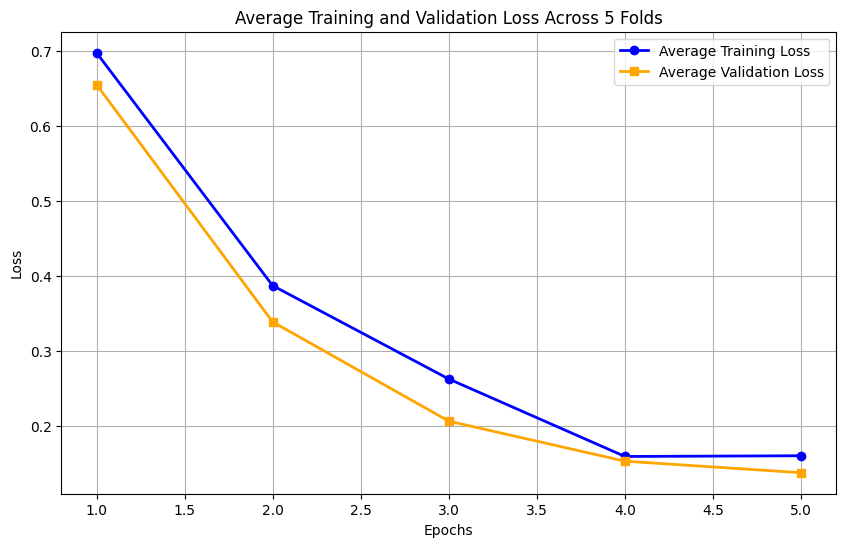

In [ ]:
# Did not include loading the model back because it is in the same file
# Importing necessary libraries
import matplotlib.pyplot as plt     #For plotting
import numpy as np

# Example: Simulated training and validation losses for 5 folds and 5 epochs
# Replace these with actual extracted data
folds = 5
epochs_per_fold = 5
training_losses = [
    [0.651200, 0.355200, 0.253300, 0.164000, 0.081700],  # Fold 1
    [0.671900, 0.420400, 0.287000, 0.156600, 0.162400],  # Fold 2
    [0.702600, 0.366400, 0.224800, 0.159300, 0.167800],  # Fold 3
    [0.710200, 0.375000, 0.217700, 0.152600, 0.166400],  # Fold 4
    [0.750800, 0.419500, 0.332300, 0.166800, 0.225700],  # Fold 5
]
validation_losses = [
    [0.636359, 0.320909, 0.158114, 0.104859, 0.093837],  # Fold 1
    [0.664029, 0.338432, 0.211414, 0.161709, 0.145265],  # Fold 2
    [0.659044, 0.323478, 0.205520, 0.153614, 0.138321],  # Fold 3
    [0.684376, 0.378368, 0.251122, 0.196454, 0.179616],  # Fold 4
    [0.630801, 0.333881, 0.208235, 0.151272, 0.134040],  # Fold 5
]

# Taking the arithmetic average of the losses across folds for each epoch
training_avg = np.mean(training_losses, axis=0)
validation_avg = np.mean(validation_losses, axis=0)

# Plotting training and validation loss
epochs = range(1, epochs_per_fold + 1)  # Epochs: 1 to 5

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_avg, label="Average Training Loss", color="blue", linewidth=2, marker="o")
plt.plot(epochs, validation_avg, label="Average Validation Loss", color="orange", linewidth=2, marker="s")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Average Training and Validation Loss Across 5 Folds")
plt.legend()
plt.grid(True)
plt.show()


This part is for drawing confusion matrix to evaluate our model classification performance

Processing Fold 1/5 for Confusion Matrix


Epoch,Training Loss,Validation Loss


Processing Fold 2/5 for Confusion Matrix
Processing Fold 3/5 for Confusion Matrix
Processing Fold 4/5 for Confusion Matrix
Processing Fold 5/5 for Confusion Matrix


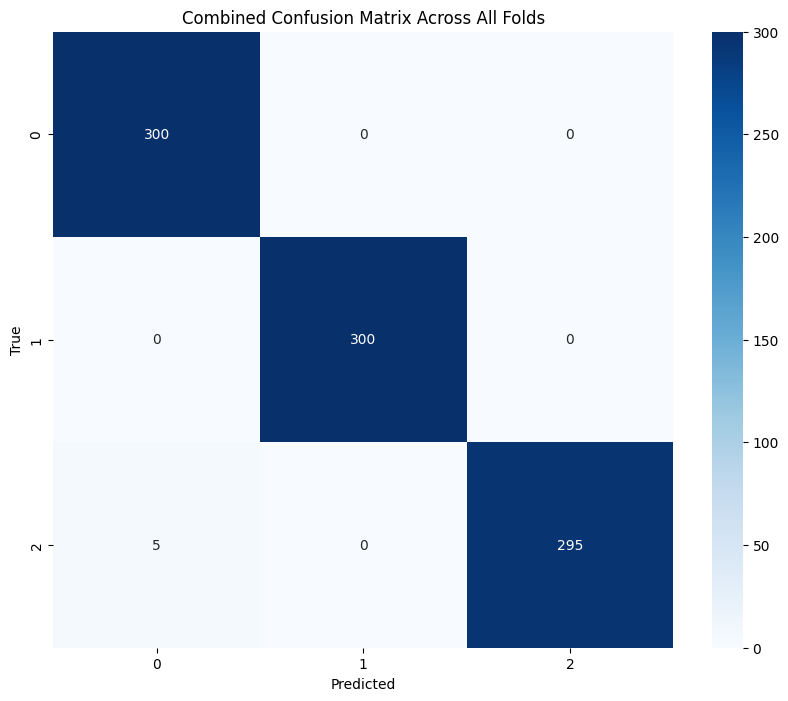

In [ ]:
# Importing necessary libraries
from sklearn.metrics import confusion_matrix    #For confusion matrix
import seaborn as sns                           #For plotting
import matplotlib.pyplot as plt
import numpy as np

# Initializing storage of lists for all true labels and predictions
all_true_labels = []
all_preds = []

# Looping through folds to collect predictions and true labels
for fold, (train_idx, val_idx) in enumerate(skf.split(df["Abstract"], df["Label"])):
    print(f"Processing Fold {fold + 1}/{num_folds} for Confusion Matrix")

    # True labels for this fold
    val_labels = df["Label"].iloc[val_idx].tolist()
    all_true_labels.extend(val_labels)

    # Predictions for this fold
    predictions = trainer.predict(val_dataset)  # Run prediction on validation dataset
    preds = np.argmax(predictions.predictions, axis=1)
    all_preds.extend(preds)

# Computing the overall confusion matrix
cm = confusion_matrix(all_true_labels, all_preds)

# Label mapping for the confusion matrix
# 0 for Astronomy, 1 for Psychology, 2 for Sociology
unique_labels = df["Label"].unique()
label_mapping = {i: label for i, label in enumerate(unique_labels)}

# Plotting confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Combined Confusion Matrix Across All Folds")
plt.show()